<a href="https://colab.research.google.com/github/workingbetter/ITNPBD5_Dissertation/blob/main/Genetic_Algorithm_on_a_Simulated_Journey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating Simulated Journey

In [ ]:
# Installing and importing libraries
!pip install deap
import random
import pandas as pd
import numpy as np
from deap import base, creator, tools, algorithms
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Creating DataFrame from provided data
data = {
    'minutes': [i for i in range(61)],
    'state_of_charge': [9, 12, 14, 16, 19, 21, 23, 26, 28, 30, 33, 36, 38, 41, 43, 46, 48, 50, 53, 55, 58, 61, 63, 65,
                       68, 70, 72, 74, 76, 77, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 90, 91, 92, 93, 93, 94, 94,
                       95, 96, 96, 97, 97, 97, 98, 98, 98, 99, 99, 99, 100]
}

# Convert data to DataFrame
charging_rate_df = pd.DataFrame(data)

# Creating DataFrame for station location data
station_data = {
    'station_number': [i for i in range(1, 126)],
    'location(mile)': [i for i in range(4, 501, 4)]
}

# Convert station data to DataFrame
station_df = pd.DataFrame(station_data)

# Convert the charging_rate_df data to numpy arrays for the interpolation function
minutes = charging_rate_df['minutes'].values
soc = charging_rate_df['state_of_charge'].values / 100  #  state of charge is given in percentages


## Plotting Battery Charging Curve

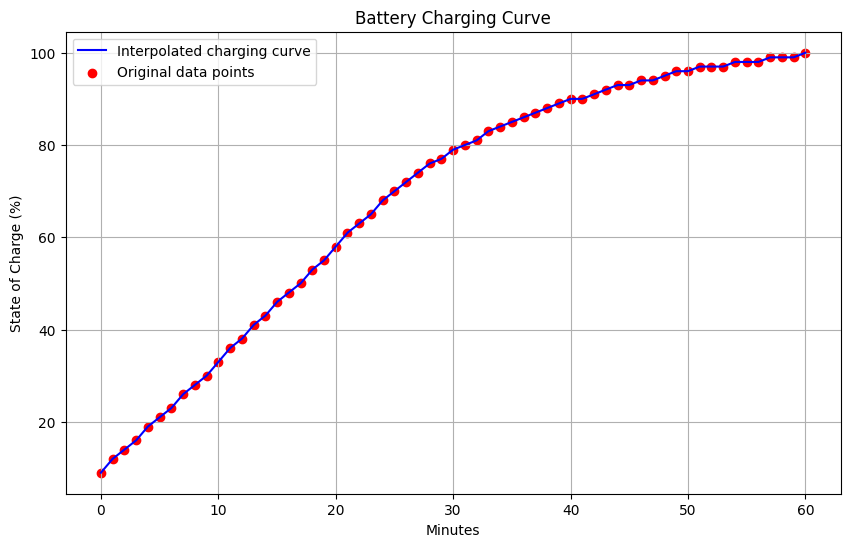

In [ ]:
# Interpolation
f = interp1d(minutes, soc, kind='linear')
new_minutes = np.linspace(0, 60, 600)  # For a smoother curve
new_soc = f(new_minutes)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(new_minutes, new_soc * 100, label="Interpolated charging curve", color='blue')
plt.scatter(minutes, soc * 100, marker='o', color='red', label="Original data points")
plt.title("Battery Charging Curve")
plt.xlabel("Minutes")
plt.ylabel("State of Charge (%)")
plt.legend()
plt.grid(True)
plt.show()

# Setting Parameters, Running GA

In [ ]:
# Assigning given values
initial_soc = 0.4  # initial state of charge
total_distance = 500  # total travel distance in miles
average_speed = 50  # average speed in mph
discharge_rate = 0.004  # discharge rate in SOC per mile
min_soc = 0.09  # minimum SOC

# GA hyperparameters
POPULATION_SIZE = 500 # Number of individuals in each generation
MUTATION_PROB = 0.2 # Probability of mutation for each individual
CROSSOVER_PROB = 0.5 # Probability of crossover for each individual
TOURNAMENT_SIZE = 3 # Size of the tournament selection group
NUMBER_OF_GENERATIONS = 150  # Total number of generations for the evolution
MUTATION_CHANCE = 0.05  # Chance to mutate each decision
STOP_PENALTY = 5  # time penalty for each stop in minutes

#Interpolates the charging time given a starting and ending state of charge.
def interpolate_charge_time(start_soc, end_soc):

    if start_soc > end_soc or start_soc < min(soc) or end_soc > max(soc):
        return 1e6  # Assign a high penalty if charging to the desired SOC is impossible

    # Locate nearest indices for the provided states of charge
    start_idx = np.searchsorted(soc, start_soc, side='left')
    if soc[start_idx] > start_soc and start_idx > 0:
        start_idx -= 1

    end_idx = np.searchsorted(soc, end_soc, side='left')
    if soc[end_idx] < end_soc and end_idx < len(soc) - 1:
        end_idx += 1

    if start_idx == end_idx:
        return 0  # Start and end SOC are the same

    # Extract values for interpolation
    start_min = minutes[start_idx]
    end_min = minutes[end_idx]
    start_soc_val = soc[start_idx]
    end_soc_val = soc[end_idx]

    # Linear interpolation formula: y = y1 + ((y2 - y1) / (x2 - x1)) * (x - x1)

    # Time interpolation at the start and end SOC
    start_time = start_min + ((minutes[start_idx+1] - start_min) / (soc[start_idx+1] - start_soc_val)) * (start_soc - start_soc_val)
    end_time = end_min + ((minutes[end_idx-1] - end_min) / (soc[end_idx-1] - end_soc_val)) * (end_soc - end_soc_val)

    return (end_time - start_time)



# Define the fitness and individual classes
if "FitnessMin" in creator.__dict__:
    del creator.__dict__["FitnessMin"]

# Define a minimization fitness class for optimization
creator.create('FitnessMin', base.Fitness, weights=(-1.0,))

if "Individual" in creator.__dict__:
    del creator.__dict__["Individual"]

# Create a new individual class with specified attributes
# including fitness, charging times, charging stations, SOC (state of charge) before and after charging
creator.create('Individual', list, fitness=creator.FitnessMin, charging_times=list(), charging_stations=list(), socs_before_charging=list(), socs_after_charging=list())

# Create a toolbox to hold functions and parameters

toolbox = base.Toolbox()

# Define how individuals are initialized
def initialize_individual():
    individual = creator.Individual()
    for _ in range(len(station_df)):
        decision = toolbox.charging_decision()
        individual.append(decision)
    return individual

# Register functions for generating individuals and populations
toolbox.register('individual', initialize_individual)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

# Register the charging decision generation function
toolbox.register('charging_decision', random.randint, 0, 1)

# Fitness evaluation function.
def evaluate(individual):
    total_time = 0
    soc = initial_soc
    previous_location = 0
    charging_times = []
    charging_stations = []
    socs_before_charging = []
    socs_after_charging = []
    stop_penalty = STOP_PENALTY

    # Loop through each decision in the individual's charging plan
    for i, decision in enumerate(individual):
        stop = decision # Extract the charging decision for this station

        # Driving time to next station
        distance = station_df.loc[i, 'location(mile)'] - previous_location
        driving_time = (distance / average_speed) * 60  # Convert hours to minutes
        total_time += driving_time

        # Update SOC and location
        soc -= distance * discharge_rate
        previous_location = station_df.loc[i, 'location(mile)']

        # Check if the SOC is enough to reach the station
        if soc < min_soc:
            return float('inf'),  # Return very high fitness value

        if stop:
            # Generate a new charging target between current SOC and 1
            new_charging_target = round(random.uniform(soc, 1), 2)

            # Cannot charge if the new target SOC is less than the current SOC
            if new_charging_target <= soc:
                return float('inf'),  # Return very high fitness value

            # Record SOC before charging
            socs_before_charging.append(soc)

            charging_time = interpolate_charge_time(soc, new_charging_target)
            charging_time += stop_penalty  # Add stop penalty to charging time
            total_time += charging_time  # Add the charging time (including the stop penalty) to the total time

            charging_times.append(charging_time)  # Record charging time (including the stop penalty)
            charging_stations.append(i)

            soc = new_charging_target  # Update SOC

            # Record SOC after charging
            socs_after_charging.append(soc)

    # Assign charging-related data to the individual
    individual.charging_times = charging_times
    individual.charging_stations = charging_stations
    individual.socs_before_charging = socs_before_charging
    individual.socs_after_charging = socs_after_charging

    return total_time,



# Mutation
def mutate(individual):
    for i in range(len(individual)):
        decision = individual[i]
        if random.random() < MUTATION_CHANCE:
            new_decision = 1 - decision # Flip the decision (0 to 1 or 1 to 0)
            individual[i] = new_decision
    return individual,

# Register the mutation function in the toolbox
toolbox.register('mutate', mutate)

# Mate individuals
def mate(ind1, ind2):
    for i in range(len(ind1)):
        if random.random() < 0.5:
            ind1[i], ind2[i] = ind2[i], ind1[i]
    return ind1, ind2

# Register the mate function in the toolbox
toolbox.register('mate', mate)

# Define the genetic operators
toolbox.register('evaluate', evaluate)
toolbox.register('select', tools.selTournament, tournsize = TOURNAMENT_SIZE)

# Define the main function to run the genetic algorithm
def main():
    # Initialize a population of individuals with specified size
    pop = toolbox.population(n=POPULATION_SIZE)

    # Create a Hall of Fame to store the best individual
    hof = tools.HallOfFame(1)

    # Create statistics object to track average and minimum fitness values
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register('Avg', np.mean)
    stats.register('Min', np.min)

    # Run the evolution process using eaSimple algorithm
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=CROSSOVER_PROB, mutpb=MUTATION_PROB, ngen=NUMBER_OF_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # Get the best individual
    best_individual = hof[0]
    total_travel_time_mins = best_individual.fitness.values[0]
    total_travel_time = f'{int(total_travel_time_mins // 60)} hours {int(total_travel_time_mins % 60)} minutes'

    # Print the total travel time
    print(f'Total travel time: {total_travel_time}')

    # Print charging times and stations
    print('Charging times: ', best_individual.charging_times)
    print('Charging stations: ', best_individual.charging_stations)

    return pop, log, hof


# Run the GA
pop, log, hof = main()

# Extract the best individual
best_individual = hof[0]


gen	nevals	Avg	Min    
0  	500   	inf	1177.47
1  	284   	inf	1144.97
2  	293   	inf	1122.4 
3  	303   	inf	1097.2 
4  	318   	inf	1097.7 
5  	272   	inf	1080.07
6  	309   	inf	1061.23
7  	306   	inf	1061.23
8  	293   	inf	1047.7 
9  	301   	inf	1011.03
10 	305   	inf	1000.47
11 	300   	inf	960.433
12 	309   	inf	966.1  
13 	297   	inf	951.667
14 	314   	inf	943.2  
15 	283   	inf	903.533
16 	318   	inf	894.633
17 	311   	inf	894.633
18 	295   	inf	867.2  
19 	290   	inf	813.767
20 	302   	inf	802.6  
21 	310   	inf	802.6  
22 	307   	inf	789.033
23 	310   	inf	771.167
24 	299   	inf	771.167
25 	287   	inf	751.933
26 	306   	inf	750.967
27 	302   	inf	736.233
28 	322   	inf	718.1  
29 	311   	inf	718.1  
30 	312   	inf	718.1  
31 	309   	inf	718.1  
32 	306   	inf	718.1  
33 	315   	inf	717.633
34 	293   	inf	718.1  
35 	299   	inf	699.567
36 	317   	inf	699.567
37 	293   	inf	699.567
38 	306   	inf	699.567
39 	279   	inf	699.567
40 	274   	inf	699.567
41 	290   	inf	699.567
42 	295   	

# Displaying the results in Suitable format

In [ ]:
# Prepare data for DataFrame
data = {
    'Charging Stations': best_individual.charging_stations,
    'Charging Time(minute)': best_individual.charging_times,
    'SOCs Before Charging': best_individual.socs_before_charging,
    'SOCs After Charging': best_individual.socs_after_charging
}

# Create DataFrame
output_df = pd.DataFrame(data)
# Extract the distance information
distances = [station_df.loc[i, 'location(mile)'] for i in best_individual.charging_stations]

# Add the distance information to the DataFrame
output_df['Distance (mile)'] = distances

if best_individual.charging_stations:
    last_charging_location = station_df.loc[best_individual.charging_stations[-1], 'location(mile)']
else:
    last_charging_location = 0  # if no charging stations were used

remaining_distance = total_distance - last_charging_location
soc_consumed = remaining_distance * discharge_rate

if best_individual.socs_after_charging:
    final_soc = best_individual.socs_after_charging[-1] - soc_consumed
else:
    final_soc = initial_soc - soc_consumed

print(f"State of Charge upon reaching final destination: {final_soc * 100:.2f}%")

display(output_df)

State of Charge upon reaching final destination: 12.20%


,Charging Stations,Charging Time(minute),SOCs Before Charging,SOCs After Charging,Distance (mile)
0,16,31.100000,0.128,0.75,68
1,43,12.400000,0.318,0.50,176
2,64,24.366667,0.164,0.64,260
3,91,23.100000,0.208,0.65,368
